In [5]:
import datetime
import json
import boto3
import io
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
#import seaborn as sns
plt.style.use('ggplot')

In [6]:
pickle_file = '../btc-autotrader/lib/data/log/2019-04-23T07:01:32.383314.pickle'

In [7]:
df = pd.read_pickle(pickle_file)

In [8]:
df.head()

,datetime,cash,cash_orig,btc_in_possession,btc_current_price,position,rate_of_change,total_value,acceleration,bid_high,ask_low,mid_price,bought_price,sold_price,target_price,size
0,2019-04-23 07:01:37.945239,45558.0,0,0.004411,602602.0,0,None,0,None,602602.0,602992.0,602797.0,0,0,0,0
0,2019-04-23 07:01:42.967029,45558.0,0,0.004411,602992.0,0,-1.36832,0,None,602602.0,602991.0,602796.0,0,0,0,0
0,2019-04-23 07:01:47.988916,45558.0,0,0.004411,602993.0,0,-1.25394,0,0.0113488,602604.0,602992.0,602798.0,0,0,0,0
0,2019-04-23 07:01:53.007240,45558.0,0,0.004411,602992.0,0,-0.790147,0,0.0921607,602924.0,602991.0,602957.0,0,0,0,0
0,2019-04-23 07:01:58.036989,45558.0,0,0.004411,602991.0,0,-0.570969,0,0.0436098,602924.0,602991.0,602957.0,0,0,0,0


In [9]:
df['spread'] = df.ask_low - df.bid_high

In [10]:
df['spread_pct_change'] = df.spread.pct_change()

In [11]:
df.loc[df.rate_of_change >= 0, 'rate_of_change_positive'] = 1
df.loc[df.rate_of_change < 0, 'rate_of_change_positive'] = -1
df.loc[df.rate_of_change >= 5, 'rate_of_change_positive'] = 2
df.loc[df.rate_of_change < -5, 'rate_of_change_positive'] = -2

In [12]:
df['btc_current_price_normalized'] = (df.btc_current_price - df.btc_current_price.mean()) / df.btc_current_price.std()


In [13]:
df['returns'] = np.log(df['btc_current_price']/df['btc_current_price'].shift(1))

In [14]:
df['strategy'] = df['rate_of_change_positive'].shift(1) * df['returns']

In [15]:
df.tail()

,datetime,cash,cash_orig,btc_in_possession,btc_current_price,position,rate_of_change,total_value,acceleration,bid_high,...,bought_price,sold_price,target_price,size,spread,spread_pct_change,rate_of_change_positive,btc_current_price_normalized,returns,strategy
0,2019-04-23 07:22:28.942301,39522.0,0,0.004315,602613.0,3,-2.21848,0,0,602222.0,...,603850,603730,0,0,391.0,-0.205285,-1.0,-1.867079,0.000000,-0.000000
0,2019-04-23 07:22:33.967082,39522.0,0,0.004315,602609.0,3,-2.21848,0,0,602222.0,...,603850,603730,0,0,387.0,-0.010230,-1.0,-1.877788,-0.000007,0.000007
0,2019-04-23 07:22:38.994905,39522.0,0,0.004315,602609.0,3,-2.21492,0,0.000708864,602222.0,...,603850,603730,0,0,321.0,-0.170543,-1.0,-1.877788,0.000000,-0.000000
0,2019-04-23 07:22:44.019918,39522.0,0,0.004315,602609.0,3,-2.21492,0,0,602225.0,...,603850,603730,0,0,253.0,-0.211838,-1.0,-1.877788,0.000000,-0.000000
0,2019-04-23 07:22:49.038339,39522.0,0,0.004315,602225.0,3,-2.21492,0,0,602222.0,...,603850,603730,0,0,250.0,-0.011858,-1.0,-2.905877,-0.000637,0.000637


In [16]:
np.exp(df[['returns', 'strategy']].sum())

returns     0.999374
strategy    1.001942
dtype: float64

/Users/sishida/.pyenv/versions/3.7.1/envs/finance-stats/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


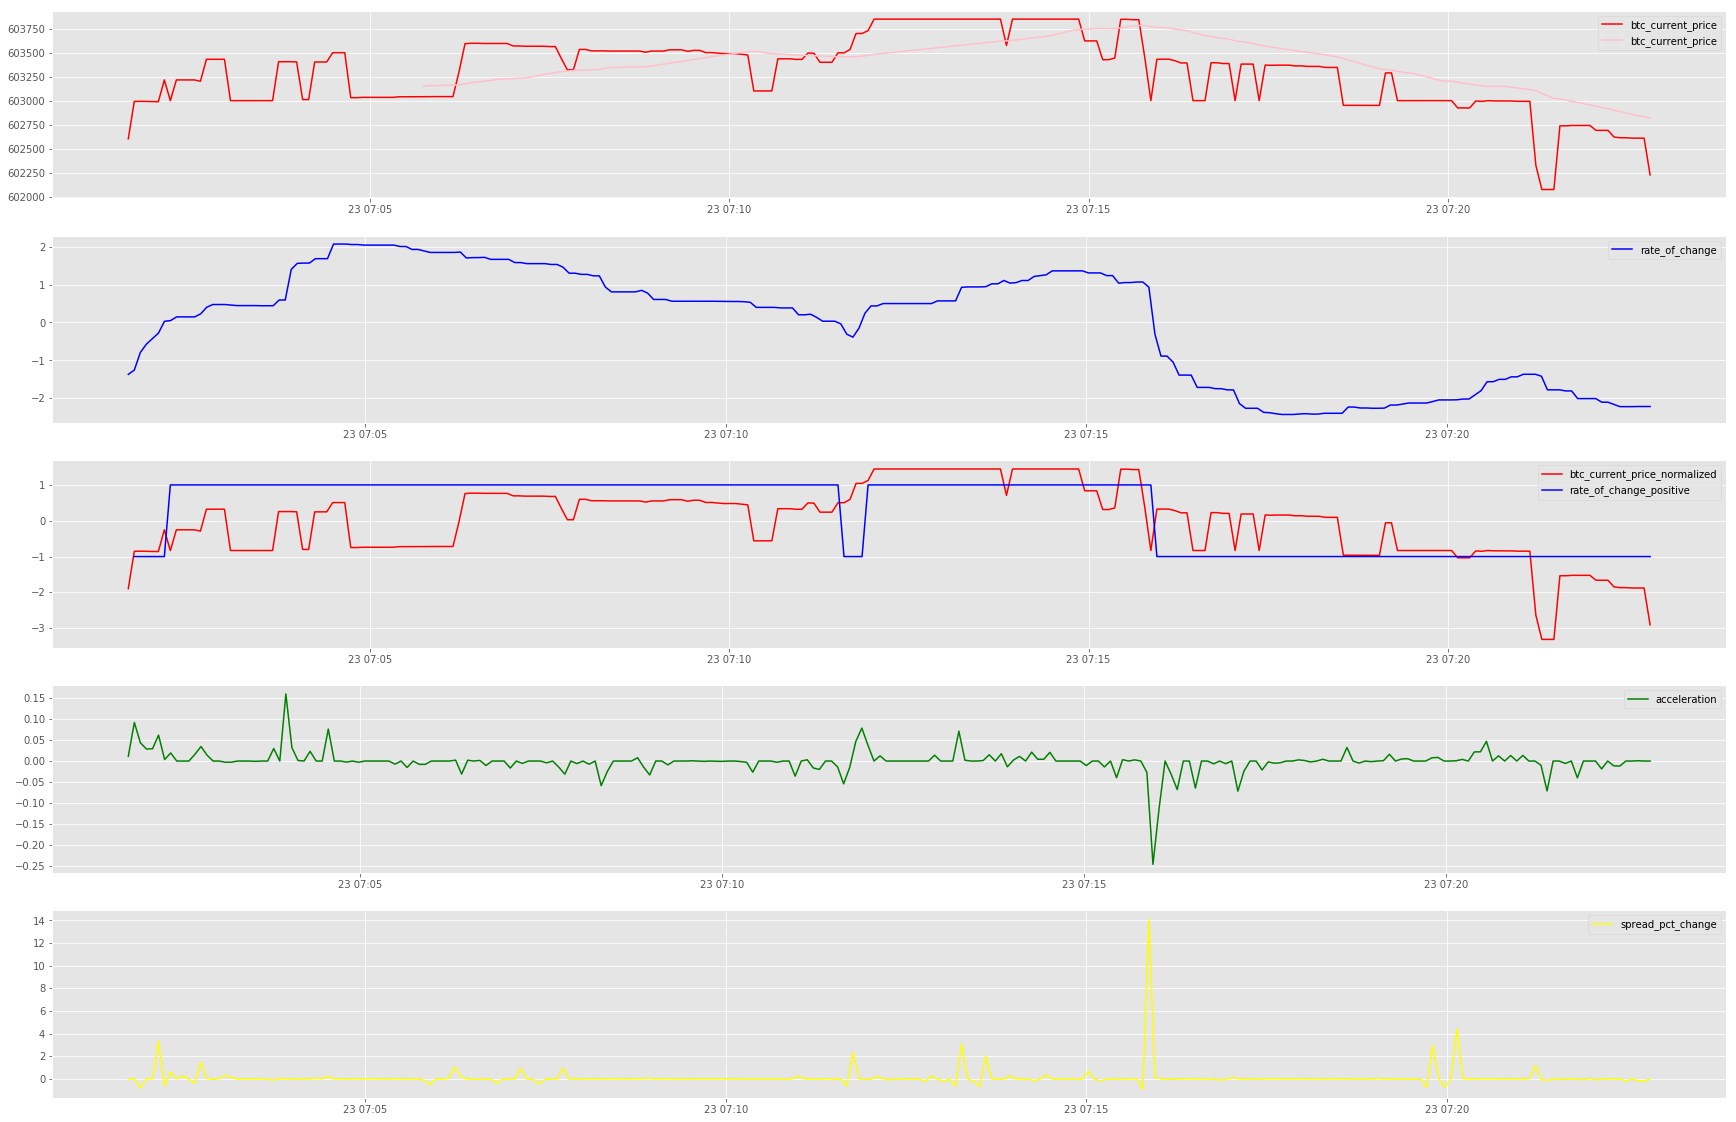

In [17]:
num = 5
fig, axes = plt.subplots(nrows=num, ncols=1, figsize=(30, 20), sharex=True)
plt.subplot(num,1,1)
plt.plot(df.datetime, df.btc_current_price, color='r')
plt.plot(df.datetime, df.btc_current_price.rolling(50).mean(), color='pink')
plt.legend()
#ax1.plot(df.datetime, df.ask_low, color='cyan', linestyle='--')
#ax1.plot(df.datetime, df.bid_high, color='magenta', linestyle='--')
#ax2.plot(df.datetime, df.spread, color='gray')
#ax1.scatter(df.datetime, df.bid_price, color='black')
plt.subplot(num,1,2)
plt.plot(df.datetime, df.rate_of_change, color='b')
plt.legend()
plt.subplot(num,1,3)
plt.plot(df.datetime, df.btc_current_price_normalized, color='r')
plt.plot(df.datetime, df.rate_of_change_positive, color='b')
plt.legend()
plt.subplot(num,1,4)
plt.plot(df.datetime, df.acceleration, color='g')
#plt.yscale('log')
plt.legend()
plt.subplot(num,1,5)
plt.plot(df.datetime, df.spread_pct_change, color='yellow')
plt.legend()
#plt.plot(df.datetime, df.spread_pct_change())
plt.show()

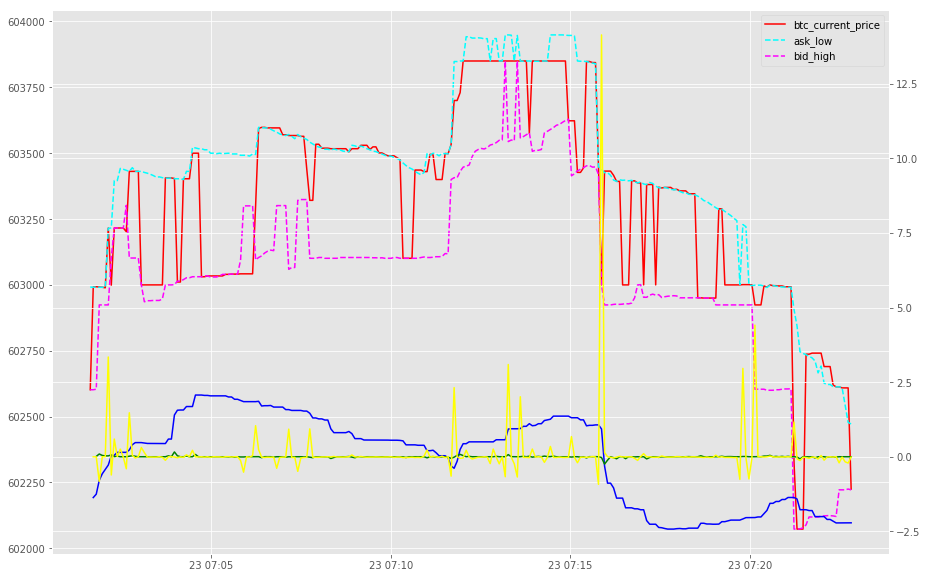

In [18]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
ax1.plot(df.datetime, df.btc_current_price, color='r')
ax1.plot(df.datetime, df.ask_low, color='cyan', linestyle='--')
ax1.plot(df.datetime, df.bid_high, color='magenta', linestyle='--')
ax1.legend()
#ax2.plot(df.datetime, df.spread, color='gray')
#ax1.scatter(df.datetime, df.bid_price, color='black')
ax2.plot(df.datetime, df.rate_of_change, color='b')
ax2.plot(df.datetime, df.acceleration, color='g')
ax2.plot(df.datetime, df.spread_pct_change, color='yellow')
#ax2.legend()
plt.show()

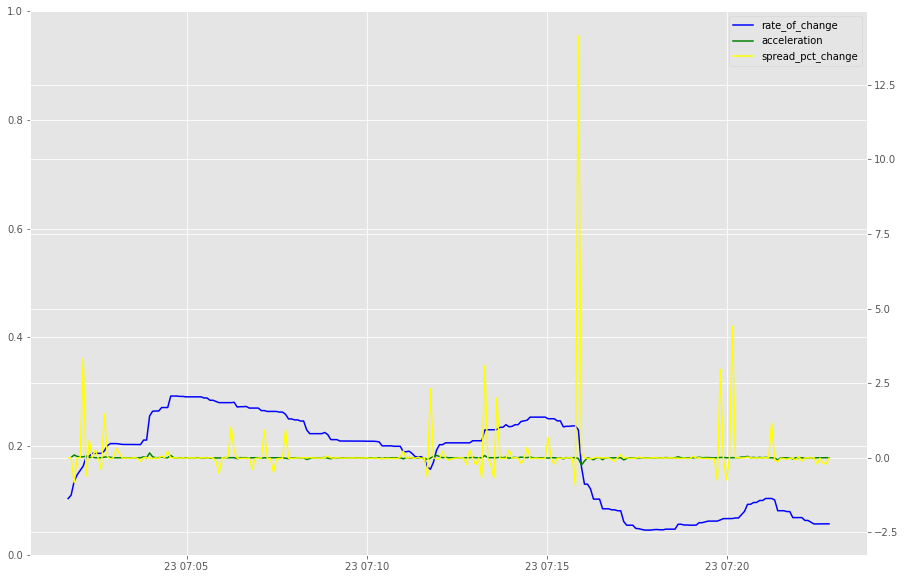

In [19]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
#ax1.plot(df.datetime, df.btc_current_price, color='r')
#ax2.plot(df.datetime, df.spread, color='gray')
#ax1.scatter(df.datetime, df.bid_price, color='black')
ax2.plot(df.datetime, df.rate_of_change, color='b')
ax2.plot(df.datetime, df.acceleration, color='g')
ax2.plot(df.datetime, df.spread_pct_change, color='yellow')
ax2.legend()
plt.show()

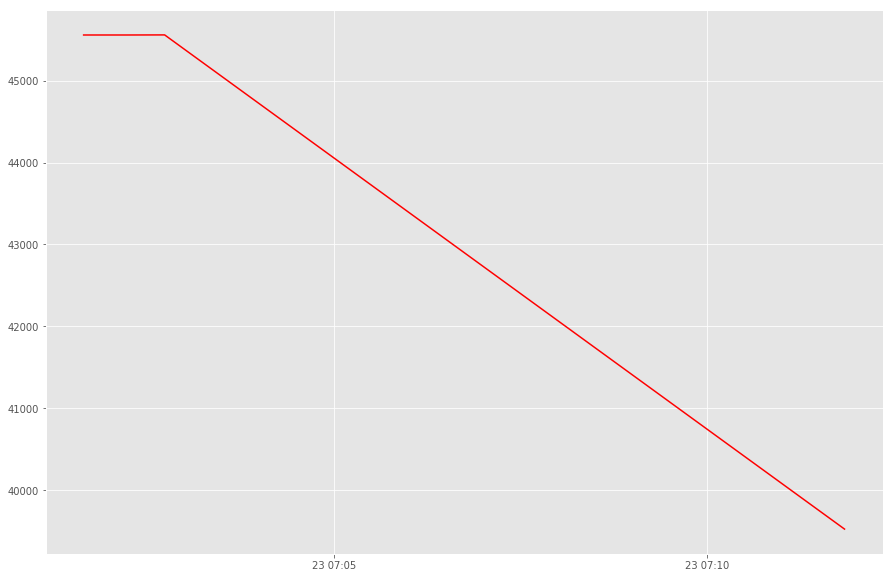

In [20]:
df_cash = df[df.position == 0]
fig, ax1 = plt.subplots(figsize=(15,10))
ax1.plot(df_cash.datetime, df_cash.cash, color='r')